# Lab 2 - Elementary Music Synthesis and Convolution
Simon Chen & Cynthia Li

In [56]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
from scipy.io import wavfile
import matplotlib.pyplot as plt
import scipy.signal
from scipy import *
import copy
import pylab as pl
from scipy import signal
import time as t
from IPython import display
import simpleaudio as sa

# 1) Music Synthesis

In this section you will be generating some tones and combining them in ways that make them better perceptible.

In [57]:
# SimpleAudio constants.
DEFAULT_SAMPLE_RATE = 8000
DEFAULT_AMPLITUDE = 1
DEFAULT_BYTES_PER_SAMPLE = 2
DEFAULT_NUM_CHANNELS = 1

# Musical note frequencies.
A = 220.0
B = A * 2 ** (2 / 12)
C = A * 2 ** (3 / 12)
E = A * 2 ** (7 / 12)

In [58]:
def play(data, num_channels=DEFAULT_NUM_CHANNELS, bytes_per_sample=DEFAULT_BYTES_PER_SAMPLE,
         sample_rate=DEFAULT_SAMPLE_RATE):
    """Plays audio data.

    Args:
        data: The audio data to be played (as a NumPy array).
        num_channels: The number of audio channels.
        bytes_per_sample: The number of bytes per sample per channel.
        sample_rate: The sample rate.
    """
    sa.play_buffer((data * 32767).astype('int16'), 1, 2, 8000).wait_done()
    

def display_envelope(signal,duration=-1,sample_rate=DEFAULT_SAMPLE_RATE,bytes_per_sample=DEFAULT_BYTES_PER_SAMPLE):

    """
    Plots the envelope of a duration of the generated audio. 

    Args:
        signal: The audio signal to be displayed (as a NumPy array).
        duration: The length of hte signal to be displayed. -1 to display entire signal.
        num_channels: The number of audio channels.
        bytes_per_sample: The number of bytes per sample per channel.
        sample_rate: The sample rate.
    """
    
    from scipy.signal import hilbert
    
    if duration < 0:
        duration = len(signal)/sample_rate
    
    n = int(duration*sample_rate)
    
    analytic_signal = hilbert(signal[0:n])
    amplitude_envelope = np.abs(analytic_signal)
        
    t = np.linspace(0,duration,len(amplitude_envelope))
    
    plt.figure()    
    plt.plot(t,amplitude_envelope)
    plt.show()

In [59]:
# defining note function 
def note(frequency, duration, amplitude=DEFAULT_AMPLITUDE, sample_rate=DEFAULT_SAMPLE_RATE):
    """Generates samples of a musical note.

    Samples are generated according to following equation:

        y(t) = A sin(wt)

    Args:
        frequency: The frequency of the note.
        duration: The length of the note in seconds.
        amplitude: The amplitude of the note.
        sample_rate: The sample rate.

    Returns:
        An array of samples representing the note.
    """
   
    n = amplitude*np.sin(2*np.pi*frequency*np.arange(sample_rate*duration)/sample_rate)
    return n
    

In [60]:
# musical score for the Scarborough Fair.
# whole note = 8000 samples / 8000 Hz = 1s
# half note = 4000 samples / 8000 Hz = 0.5s
# quarter note = 2000 samples / 8000 Hz = 0.25s
score = [(A, 0.5), (A, 0.25), (E, 0.25), (E, 0.25), (E, 0.25), (B, 0.25), (C, 0.25), (B, 0.25), (A, 1)]
notes = [note(f,d) for (f,d) in score] # create list of notes
song = np.concatenate(notes) # concatenate

# Use the play function to verify the results
play(song)


## Volume Variations

In [61]:
# Volume Variation Function Attack, Decay, Sustain and Release (ADSR)
def adsr(note):
    """Generates an ADSR envelope and applies it to a note.

        A: Linear increase to 60% amplitude over 20% length.
        D: Linear decrease to 50% amplitude over 4% length.
        S: Constant 50% amplitude over 40% length.
        R: Linear decrease to 0% amplitude over 36% length.

    Args:
        note: The note to be modified.

    Returns:
        A note that has been scaled by the ADSR envelope.
    """
    # TO DO: Enter code here to finish the adsr function
    l=len(note)
    
    lA=round(l*0.2)
    lD=round(l*0.04)
    lS=round(l*0.4)
    lR=round(l*0.36)
    # form the function of each segment
    adsr_A=np.arange(0, lA, 1)*(0.6/lA)
    adsr_D=0.6-np.arange(0, lD, 1)*(0.1/lD)
    adsr_S=np.linspace(0.5,0.5,lS)
    adsr_R=0.5-np.arange(0, lR, 1)*(0.5/lR)
    # form the adsr-processed note by each part
    partA=note[0:lA]*adsr_A
    partD=note[lA:(lA+lD)]*adsr_D
    partS=note[(lA+lD):(lA+lD+lS)]*adsr_S
    partR=note[(lA+lD+lS):(lA+lD+lS+lR)]*adsr_R
    adsr_note=np.concatenate((partA,partD, partS, partR))
    return adsr_note

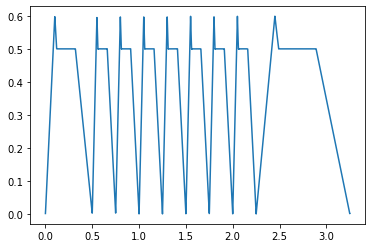

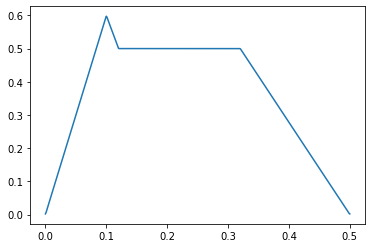

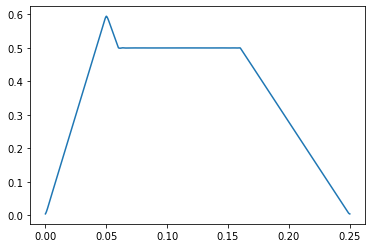

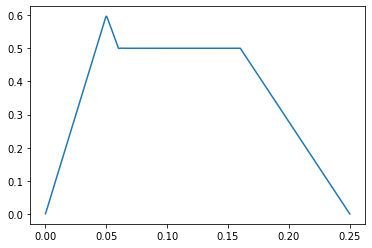

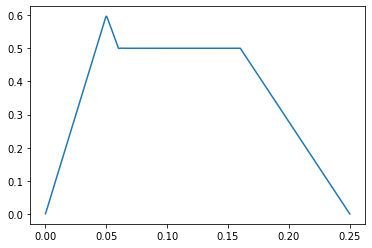

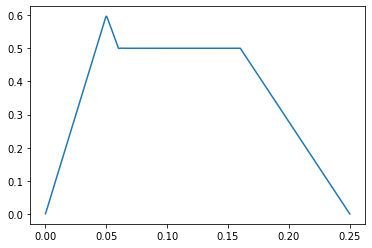

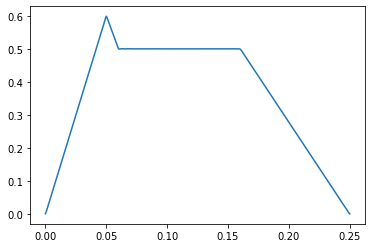

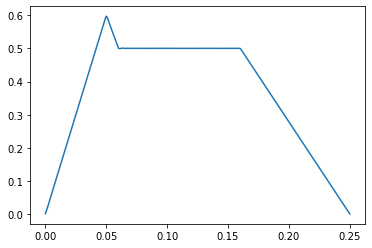

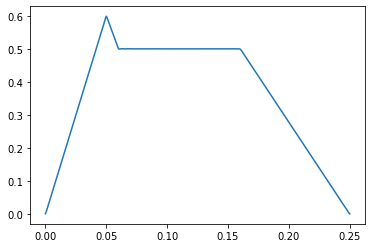

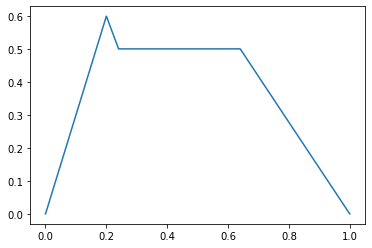

In [62]:
# Use your function Apply an ADSR envelope to each note.
adsr_notes=[adsr(n) for n in notes]
adsr_song=np.concatenate(adsr_notes)

# Play the audio sample
play(adsr_song)

# Display the envelope
display_envelope(adsr_song)
for note in adsr_notes:
    display_envelope(note)

In [63]:
def overlap(notes, offset):
    """Joins notes together with overlap between consecutive notes.

    Args:
        notes: An array of notes to be joined.
        offset: The amount of allowable overlap between consecutive notes.

    Returns:
        A score made from the input notes.
    """
    # TO DO: Enter code here to finish the overlap function
    '''
    size=len(notes)
    for i in range(size-1):
        length=len(notes[i])
        cur=notes[i]
        nex=notes[i+1]
        for j in range(offset):
            cur[length-1-j]=cur[length-1-j]+nex[j]
    '''
    extend=[]
    # extend each note to facilitate blending later
    for i in range(len(notes)):
        length=len(note)
        temp=np.pad(note, (offset,offset),'constant',constant_values=(note[offset], note[length-1-offset]))
        extend.append(temp)
    
    size=len(extend)
    overlap=[]
    for i in range(size-1):
        length=len(extend[i])
        overlap.append(notes[i]) # append the original note first
        blending=extend[i][(length-offset):length]+extend[i+1][0:offset] # create the blending area
        # fix any exceeding amplitude if exists
        # Since the profix has a fixed value, and that the start of note has increasing amplitude, 
        # we only need to check whether the last value exceeds 1.
        if blending[offset-1] > 1: 
            blending = np.ones((offset,), dtype=int)
        if blending[offset-1] < -1: 
            blending = -1 * np.ones((offset,), dtype=int)
        overlap.append(blending)
    overlap.append(notes[size-1])
    return overlap

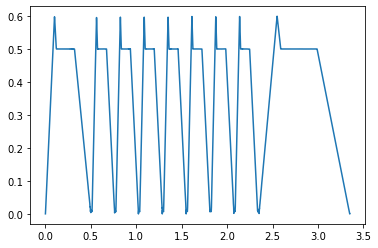

In [64]:
# Smooth the sound by overlapping the notes.
overlap_score=overlap(notes, 100)

# this builds the signal after applying adsr and then overlapping notes
adsr_n=[adsr(note) for note in overlap_score]
adsr_s=np.concatenate(adsr_n)

# Play the audio sample
play(adsr_s)

# Display the envelope
display_envelope(adsr_s)


## Discussion

#### Is the application of an ADSR envelope an invertible operation? How might the effects of volume variation be inverted?
    
    Yes, the envelope is an invertible operation. We can restore the volume by applying the inserse system of each segment to each segment. Eg.for segmentC we can simply scale the amplitude of ASDR_note by 2.

#### What is the effect of the ADSR on the energy of a signal?
    
    The energy should be lowered as its frequency didn't change but the amplitude(volume) has been decreased.

#### Is an envelope function a linear operation?

    Yes, this is a linear operation.
    

# 2) One Dimensional Convolution Sum

In [65]:
# TO DO: define the basic signal generating functions

# step function
def u(t):
    return 1.0*(t>0)
# ramp function
def r(t):
    return t*(t>0)  

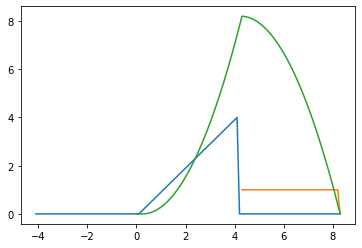

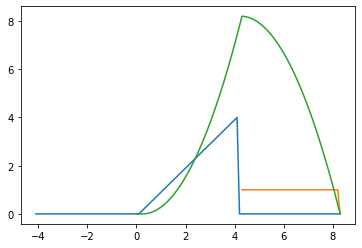

In [66]:
# Use a 4s long ramp sampled at 10 samples/s for the signal
# Use a 4s long step signal for the kernel

end_time=4 # end time in the time interval [0,end_time]
fs=10 # sampling frequency
ts=1/fs #sampling time

# TO DO: create the time vector
tvec = np.arange(0, 4*fs+1,1)*ts

# TO DO: define the convolution kernel
kernel = u(tvec)

nKern = len(kernel)

kflip = kernel[::-1] 

# TO DO: define the signal to be convolved with the kernel
signal1= r(tvec)
# zero-padded data for convolution
signal1 = np.concatenate( (np.zeros(nKern+1),signal1,np.zeros(nKern+1)) ,axis=0)
nSign = len(signal1)


nConv = nSign + nKern - 1
# initialize convolution output
conv_res = np.zeros(nConv)

## convolution in animation

# run convolution
for ti in range(nKern,nConv-nKern+2):    
    # get a chunk of data
    tempdata = signal1[ti-nKern:ti]
    
    # compute dot product (don't forget to flip the kernel backwards!)
    conv_res[ti] = np.dot(tempdata,kflip)*ts
    
    # draw plot
    pl.cla() # clear the axis
    plt.plot((np.arange(0,nSign)-nKern)/fs,signal1)
    plt.plot((np.arange(ti-nKern,ti)-nKern)/fs,kflip)
    plt.plot((np.arange(nKern,ti)-nKern)/fs,conv_res[nKern:ti])
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    t.sleep(.01)
    

# cut off edges
conv_res = conv_res[nKern:-nKern]

## Discussion


- **If you do not normalize your computed convolution sum by dividing by the sampling rate, the magnitude is actually incorrect and does not represent the convolution result.  Why is dividing by sampling rate or multiplying by sampling time important?  (Hint:  you have done this in EE 235, checkback with the relevant labs and you should find your answer)**

    How convolution sum works is similar to the Riemann sum in mathematics: it's summing up the small piece of area represented by each sample. However, from Riemann sum, we know that the area of each piece is y(x) times dx, so here it should be the value of the sample times the sampling time. However, if we do not divide the sum by sampling rate (in other words, multiplying the sampling time), it is considering dx to be 1, which is incorrect, and would lead to a result with much higher magnitude.

- **How is the convolution sum different from the convolution integral?**

    Convolution sum is summing the area of each sample for calculating convolution in discrete time, while convolution integral is for calculating convolution in continuous time.